In [1]:
import pyroomacoustics as pra

import os
from tqdm import tqdm

import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader

from einops import rearrange

from src.dataset import SignalDataset, TRUNetDataset
from src.loss import loss_tot, loss_MR, loss_MR_w
from models.model1d_stream_med_1dphm import TRUNet 

from IPython.display import Audio

import soundfile as sf
import yaml

from NISQA_s.src.core.model_torch import model_init
from NISQA_s.src.utils.process_utils import process # process_
from NISQA_s.src.utils.train_utils import yamlparser

from NISQA.nisqa.NISQA_lib import NISQA_DIM

import matplotlib.pyplot as plt

In [2]:
DATA_DIR = os.path.join("..", "data", "data_thchs30")
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")
RIR_DIR = os.path.join("..", "data", "RIRs")
NOISE_DIR = os.path.join("..", "data", "test-noise", "noise", "white")
CHKP_DIR = os.path.join("..", "checkpoints")

np.set_printoptions(precision=3)
torch.set_printoptions(precision=3)

In [3]:
N_FFTS = 512
HOP_LENGTH = 256

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"It's {DEVICE} time!!!")

It's cuda time!!!


In [4]:
# import torchaudio
# from torchaudio.transforms import Resample
# from random import uniform, choice
# SR = 16_000
# 
# signal_rir, sample_rate = torchaudio.load("/home/zakhar/ems_dereverb/data/data_thchs30/train_1/gt.wav")
# if sample_rate != SR:
#     resampler = Resample(sample_rate, SR)
#     signal_rir = resampler(signal_rir)
# WALLS_KEYWORDS = ["hard_surface", "ceramic_tiles", "plasterboard", "wooden_lining", "glass_3mm"]
# FLOOR_KEYWORDS = ["linoleum_on_concrete", "carpet_cotton"]
# CEILING_KEYWORDS = ["ceiling_plasterboard", "ceiling_fissured_tile", "ceiling_metal_panel", ]
# 
# snr = (-5, 10)
# room_square = (7., 14.)
# room_height = (3., 4.)
# 
# 
# def simulate_rir_shoebox(signal: torch.Tensor) -> torch.Tensor:
#     square = uniform(*room_square)
#     width = uniform(2.5, square * 0.75)
#     length = square / width
#     height = uniform(*room_height)
# 
#     rt60 = uniform(0.1, 0.7)  # Делать длинный ревёрб
#     room_dim = [length, width, height]
# 
#     e_absorption, max_order = pra.inverse_sabine(rt60, room_dim)
# 
#     wall = pra.Material(choice(WALLS_KEYWORDS))
#     ceil = pra.Material(choice(CEILING_KEYWORDS))
#     floor = pra.Material(choice(FLOOR_KEYWORDS))
# 
#     material = {"east": wall, "west": wall, "north": wall, "south": wall, "ceiling": ceil, "floor": floor}
# 
#     room = pra.ShoeBox(room_dim, fs=SR, materials=material, max_order=max_order,
#                        use_rand_ism=True, max_rand_disp=0.05, ray_tracing=False)
# 
#     source_locs = [uniform(0.01, length), uniform(0.01, width), uniform(1.0, 2.0)]
#     mic_locs = np.array([x * 0.98 for x in source_locs])[:, None]
# 
#     room.add_source(source_locs, signal=signal.squeeze(), delay=0.5)
# 
#     room.add_microphone_array(mic_locs)
#     room.compute_rir()
#     room.simulate()  # Внутри есть параметр snr, возможно, он пригодится
# 
#     return room.rir[0][0]
# 
# 
# for i in range(0, 50):
#     rir = simulate_rir_shoebox(signal_rir)
#     # print(type(rir[None, :]))
#     torchaudio.save(os.path.join(RIR_DIR, f'rir_{str(i)}.wav'), src=torch.from_numpy(rir[None, :]), sample_rate=SR,
#                     format='wav')

In [5]:
train_dataset = TRUNetDataset(TRAIN_DIR, sr=16_000, noise_dir=NOISE_DIR, rir_dir=RIR_DIR, snr=10, return_noise=True, return_rir=True)
test_dataset = TRUNetDataset(TEST_DIR, sr=16_000, noise_dir=NOISE_DIR, snr=10, rir_dir=RIR_DIR, return_noise=True, return_rir=True)

In [6]:
state_d = torch.load(os.path.join(CHKP_DIR, "tru-net_chkp", "trunet_chime#8.pt"), weights_only=False)

model = TRUNet(nfft=512, hop=256)
model.load_state_dict(state_d["model_state_dict"])

<All keys matched successfully>

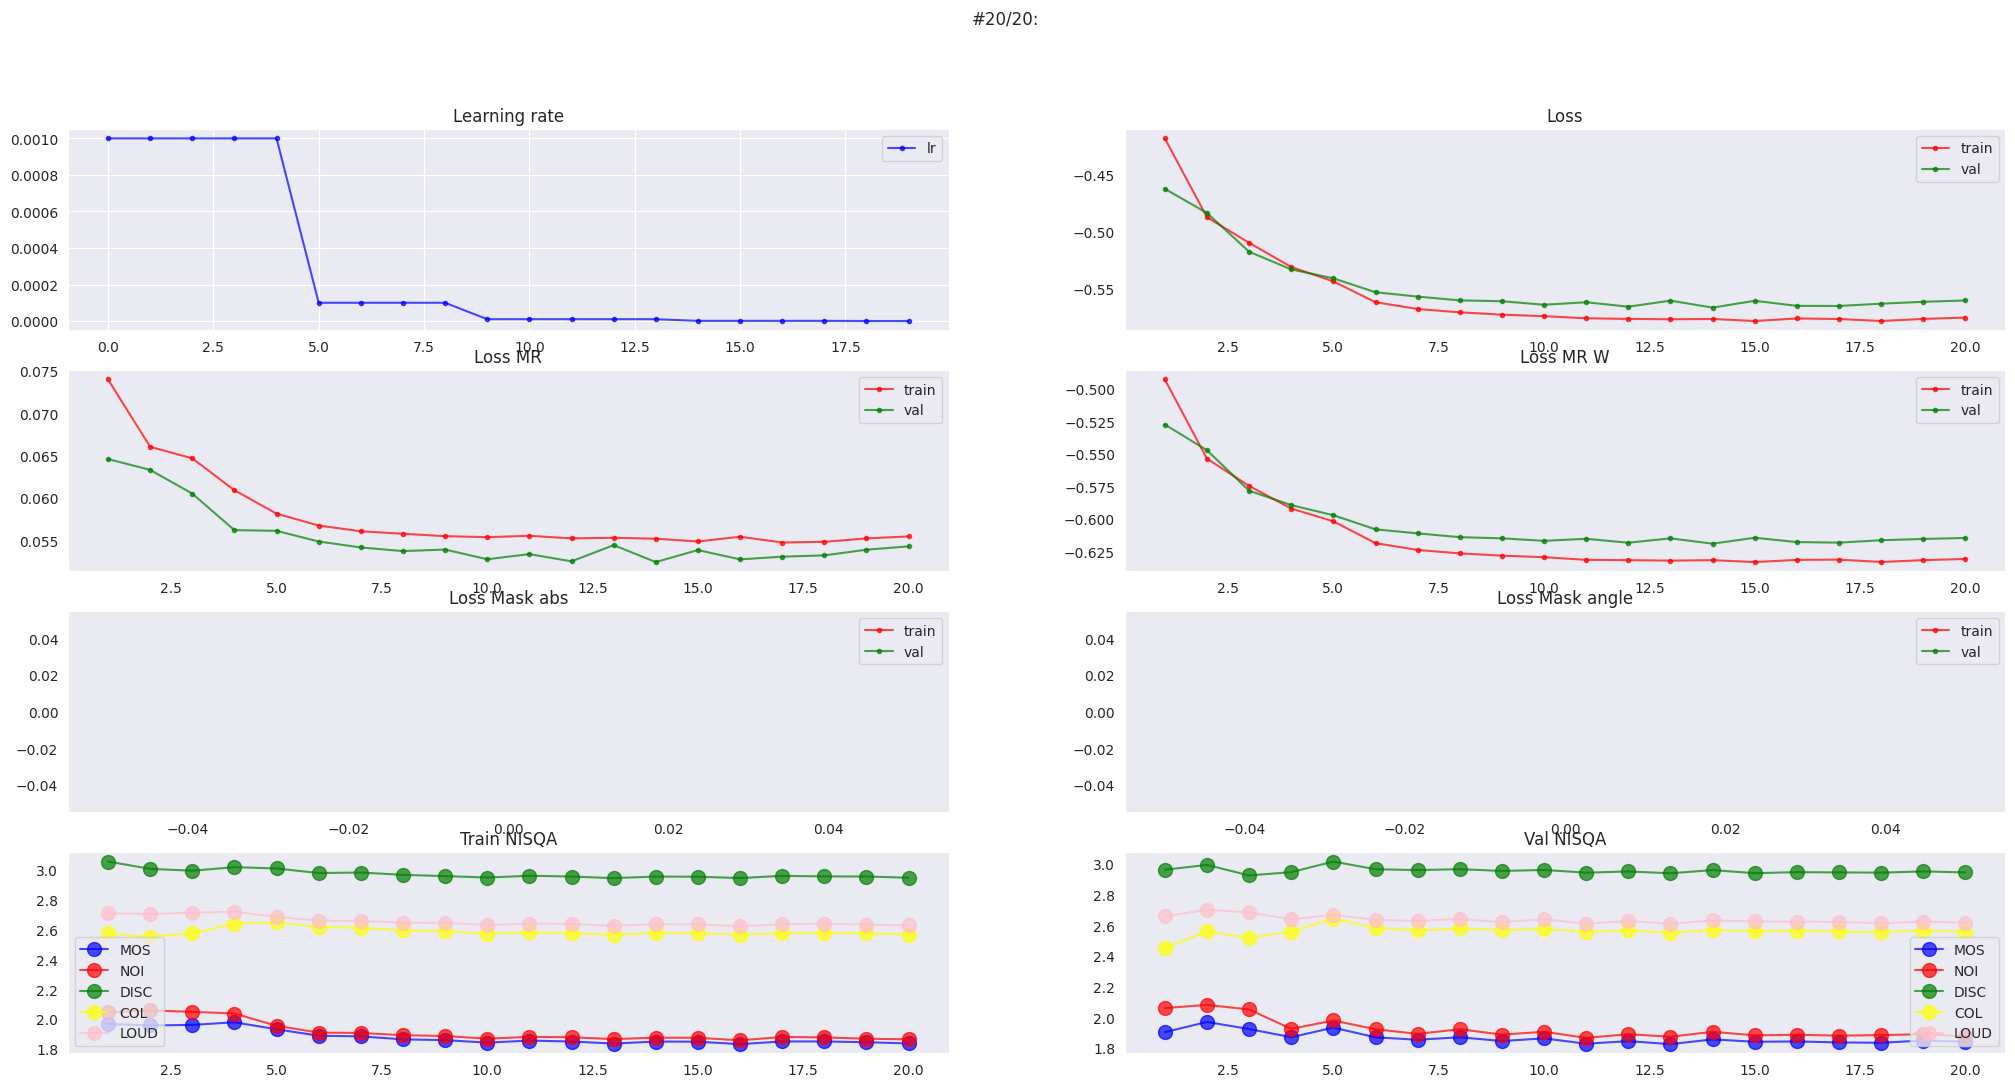

In [7]:
hh = 4
ww = 2
plt_ind = 1
fig, ax = plt.subplots(hh, ww, figsize=(25, 12))
fig.suptitle(f'#{state_d["epoch"]}/{state_d["epoch"]}:')


plt.subplot(hh, ww, plt_ind)
plt.title('Learning rate')
plt.plot(state_d["plots"]["learning rate"], 'b.-', label='lr', alpha=0.7)
plt.legend()
plt_ind += 1

plt.subplot(hh, ww, plt_ind)
plt.title('Loss')
plt.plot(np.arange(1, state_d["epoch"] + 1), state_d["plots"]['train loss'], 'r.-', label='train', alpha=0.7)
plt.plot(np.arange(1, state_d["epoch"] + 1), state_d["plots"]['val loss'], 'g.-', label='val', alpha=0.7)
plt.grid()
plt.legend()
plt_ind += 1

plt.subplot(hh, ww, plt_ind)
plt.title('Loss MR')
plt.plot(np.arange(1, state_d["epoch"] + 1), state_d["plots"]['train loss_mr'], 'r.-', label='train', alpha=0.7)
plt.plot(np.arange(1, state_d["epoch"] + 1), state_d["plots"]['val loss_mr'], 'g.-', label='val', alpha=0.7)
plt.grid()
plt.legend()
plt_ind += 1

plt.subplot(hh, ww, plt_ind)
plt.title('Loss MR W')
plt.plot(np.arange(1, state_d["epoch"] + 1), state_d["plots"]['train loss_mr_w'], 'r.-', label='train', alpha=0.7)
plt.plot(np.arange(1, state_d["epoch"] + 1), state_d["plots"]['val loss_mr_w'], 'g.-', label='val', alpha=0.7)
plt.grid()
plt.legend()
plt_ind += 1

plt.subplot(hh, ww, plt_ind)
plt.title('Loss Mask abs')
plt.plot(np.arange(1, state_d["epoch"] + 1), state_d["plots"]['train loss_mask_abs'], 'r.-', label='train', alpha=0.7)
plt.plot(np.arange(1, state_d["epoch"] + 1), state_d["plots"]['val loss_mask_abs'], 'g.-', label='val', alpha=0.7)
plt.grid()
plt.legend()
plt_ind += 1

plt.subplot(hh, ww, plt_ind)
plt.title('Loss Mask angle')
plt.plot(np.arange(1, state_d["epoch"] + 1), state_d["plots"]['train loss_mask_angle'], 'r.-', label='train', alpha=0.7)
plt.plot(np.arange(1, state_d["epoch"] + 1), state_d["plots"]['val loss_mask_angle'], 'g.-', label='val', alpha=0.7)
plt.grid()
plt.legend()
plt_ind += 1

nisqa_plot = torch.cat(state_d["plots"]['train NISQA'])
# if len(nisqa_plot.shape) == 1:
#     nisqa_plot = nisqa_plot[None, :]
# print(nisqa_plot.shape)
plt.subplot(hh, ww, plt_ind)
plt.title('Train NISQA')
plt.plot(np.arange(1, state_d["epoch"] + 1), nisqa_plot[:, 0], '.-', label='MOS', alpha=0.7, markersize=20, color="blue")
plt.plot(np.arange(1, state_d["epoch"] + 1), nisqa_plot[:, 1], '.-', label='NOI', alpha=0.7, markersize=20, color="red")
plt.plot(np.arange(1, state_d["epoch"] + 1), nisqa_plot[:, 2], '.-', label='DISC', alpha=0.7, markersize=20, color="green")
plt.plot(np.arange(1, state_d["epoch"] + 1), nisqa_plot[:, 3], '.-', label='COL', alpha=0.7, markersize=20, color="yellow")
plt.plot(np.arange(1, state_d["epoch"] + 1), nisqa_plot[:, 4], '.-', label='LOUD', alpha=0.7, markersize=20, color="pink")
plt.grid()
plt.legend()
plt_ind += 1

nisqa_plot = torch.cat(state_d["plots"]['val NISQA'], dim=0)
# if len(nisqa_plot.shape) == 1:
#     nisqa_plot = nisqa_plot[None, :]
plt.subplot(hh, ww, plt_ind)
plt.title('Val NISQA')
plt.plot(np.arange(1, state_d["epoch"] + 1), nisqa_plot[:, 0], '.-', label='MOS', alpha=0.7, markersize=20, color="blue")
plt.plot(np.arange(1, state_d["epoch"] + 1), nisqa_plot[:, 1], '.-', label='NOI', alpha=0.7, markersize=20, color="red")
plt.plot(np.arange(1, state_d["epoch"] + 1), nisqa_plot[:, 2], '.-', label='DISC', alpha=0.7, markersize=20, color="green")
plt.plot(np.arange(1, state_d["epoch"] + 1), nisqa_plot[:, 3], '.-', label='COL', alpha=0.7, markersize=20, color="yellow")
plt.plot(np.arange(1, state_d["epoch"] + 1), nisqa_plot[:, 4], '.-', label='LOUD', alpha=0.7, markersize=20, color="pink")
plt.grid()
plt.legend()
plt_ind += 1

plt.show()

In [8]:
# state_d["plots"]['val loss']

In [9]:
def vorbis_window(winlen, device="cuda"):
    sq = torch.sin(torch.pi/2*(torch.sin(torch.pi/winlen*(torch.arange(winlen)-0.5))**2)).float()
    return sq

### Evaluation

In [10]:
input_sig, gt, gt_noise, gt_rir = train_dataset[0]

In [11]:
window = vorbis_window(512)

input_sig_chunked = input_sig.unfold(-1, 16_000 * 2, 16_000 * 2)

input_sig_chunked = input_sig_chunked.reshape(-1, input_sig_chunked.shape[-1])

spec = torch.stft(
            input_sig_chunked,
            n_fft=N_FFTS,
            hop_length=HOP_LENGTH,
            # onesided=True,
            win_length=512,
            window=window,
            return_complex=True,
            normalized=True,
            center=True
        ) 

In [12]:
input_sig.shape, input_sig_chunked.shape, spec.shape

(torch.Size([1, 167648]), torch.Size([5, 32000]), torch.Size([5, 257, 126]))

In [13]:
model.eval()

fgru_hidden_size = 64
tgru_hidden_size = 128

h_f = torch.randn(2, spec.shape[0] * spec.shape[-1], fgru_hidden_size, )
h_t = torch.randn(1, 16, tgru_hidden_size, )
output, noise, rir, _, _ = model(spec.abs(), spec.angle(), spec.real, spec.imag, h_f, h_t)
output = torch.polar(torch.abs(output), spec.angle())

# signal = signal * spec

In [14]:
window = vorbis_window(512)
out_wave = torch.istft(output, n_fft=N_FFTS, hop_length=HOP_LENGTH, win_length=512,
                       window=window,
                       return_complex=False,
                       normalized=True,
                       center=True)# [..., 20:-20]

# out_wave, _ = SignalDataset.normalize_audio(out_wave)
# out_wave = 2 * (out_wave - out_wave.min()) / (out_wave.max() - out_wave.min() + 1e-8) - 1

# out_noise = torch.istft(noise * spec , n_fft=N_FFTS, hop_length=HOP_LENGTH, win_length=512,
#                        window=window,
#                        return_complex=False,
#                        normalized=True,
#                        center=True)
# out_noise, _ = SignalDataset.normalize_audio(out_noise)
# # out_noise = 2 * (out_noise - out_noise.min()) / (out_noise.max() - out_noise.min() + 1e-8) - 1
# 
# out_rir = torch.istft(rir * spec , n_fft=N_FFTS, hop_length=HOP_LENGTH, win_length=512,
#                        window=window,
#                        return_complex=False,
#                        normalized=True,
#                        center=True)
# out_rir, _ = SignalDataset.normalize_audio(out_rir)
# out_rir = 2 * (out_rir - out_rir.min()) / (out_rir.max() - out_rir.min() + 1e-8) - 1

In [15]:
# input_sig, gt, gt_noise, gt_rir = train_dataset[0]
# 
# window = vorbis_window(512).cuda()
# input_sig = input_sig.cuda()
# gt = gt.cuda()
# 
# # input_sig = input_sig.unfold(-1, 16_000 * 2, 16_000 * 2)
# # gt = gt.unfold(-1, 16_000 * 2, 16_000 * 2)
# 
# input_spec = torch.stft(
#     input_sig,
#     n_fft=N_FFTS,
#     hop_length=HOP_LENGTH,
#     # onesided=True,
#     win_length=512,
#     window=window,
#     return_complex=True,
#     normalized=True,
#     center=True
# )
# 
# h_f = torch.randn(2, input_spec.shape[0] * input_spec.shape[-1], fgru_hidden_size, ).cuda()
# h_t = torch.randn(1, 16, tgru_hidden_size,).cuda()
# 
# model = model.cuda()
# output_d, output_n, output_r, _, _ = model(input_spec.abs(), input_spec.real, input_spec.imag, h_f, h_t)
# 
# out = torch.polar(torch.abs(output_d), input_spec.angle())
# 
# window = vorbis_window(512).cuda()
# # print(output_d.shape)
# out_wave = torch.istft(out, n_fft=N_FFTS, hop_length=HOP_LENGTH, win_length=512,
#                        window=window,
#                        # onesided=True,
#                        return_complex=False,
#                        normalized=True,
#                        center=True)#, length=gt_signal.shape[-1])
# 
# # loss = loss_tot(out_wave, gt_signal.squeeze(0), out_noise, noise, out_rir, rir).squeeze(0)
# loss_MR(out_wave, gt) * 100
# # loss_mr_w = loss_MR_w(out_wave, gt_signal)
# 
# # loss = loss_mr # + loss_mr_w

In [16]:
out_wave = out_wave.reshape(-1)

In [17]:
out_wave.min()

tensor(-0.927, grad_fn=<MinBackward1>)

In [18]:
Audio(gt.cpu().numpy(), rate=16_000)

In [19]:
Audio(input_sig.cpu().numpy(), rate=16_000)

In [20]:
Audio(out_wave.cpu().detach().numpy(), rate=16_000)

In [21]:
import torchaudio

tmp, sr = torchaudio.load("output.wav")

Audio(tmp, rate=sr)

In [22]:
from scipy.io.wavfile import write

# audio = sd.rec(int(duration * samplerate), samplerate=16_000, channels=1)
# sd.wait()  # дождаться окончания записи

write('input_sig_full.wav', 16_000, input_sig.cpu().detach().numpy()[0])
write('gt_full.wav', 16_000, gt.cpu().detach().numpy()[0])
write('output_full.wav', 16_000, out_wave.cpu().detach().numpy())

In [23]:
max_len = min(out_wave.shape[-1], gt.shape[-1])

### Loss(output, gt)

In [24]:
loss_MR(out_wave[..., :max_len], gt[..., :max_len]) * 100#, out_noise[..., :max_len], gt_noise[..., :max_len], out_rir[..., :max_len], gt_rir[..., :max_len])

/home/zakhar/ems_dereverb/src/loss.py:32: UserWarning: Using a target size (torch.Size([1, 513, 626])) that is different to the input size (torch.Size([513, 626])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss += F.mse_loss(Y_abs, S_abs)
/home/zakhar/ems_dereverb/src/loss.py:32: UserWarning: Using a target size (torch.Size([1, 257, 1251])) that is different to the input size (torch.Size([257, 1251])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss += F.mse_loss(Y_abs, S_abs)
/home/zakhar/ems_dereverb/src/loss.py:32: UserWarning: Using a target size (torch.Size([1, 129, 2501])) that is different to the input size (torch.Size([129, 2501])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss += F.mse_loss(Y_abs, S_abs)


tensor(0.902, grad_fn=<MulBackward0>)

### Loss(input, gt)

In [25]:
loss_MR(input_sig[..., :max_len], gt[..., :max_len]) * 100# , out_noise[..., :max_len], out_noise[..., :max_len], out_rir[..., :max_len], out_rir[..., :max_len])

tensor(1.801)

### Loss(output, input)

In [26]:
loss_MR(out_wave[..., :max_len], input_sig[..., :max_len]) * 100

tensor(0.522, grad_fn=<MulBackward0>)

### Waveform plots

In [27]:
def plot_waveform(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle("waveform")

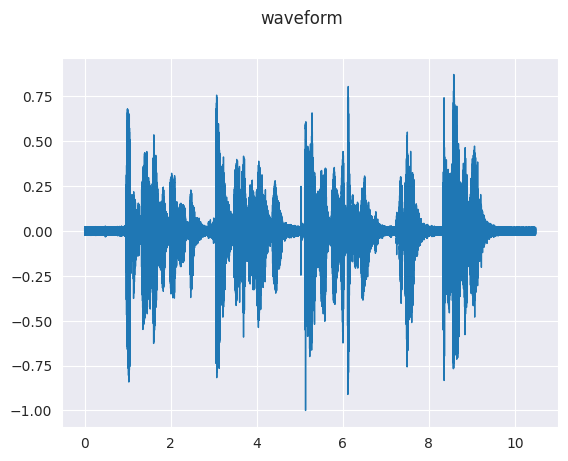

In [28]:
plot_waveform(input_sig.detach(), 16_000)

In [29]:
plot_waveform(out_wave.detach(), 16_000)

ValueError: not enough values to unpack (expected 2, got 1)

In [ ]:
plot_waveform(gt.detach(), 16_000)